In [1]:
# Import Library yang dibutuhkan
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import keras
import keras.utils

from sklearn import preprocessing
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
# from keras.callbacks import ModelCheckpoint, EarlyStopping

import time
from keras import metrics

In [2]:
MAX_SEQUENCES_LENGTH = 50 # Maximum kata pada kalimat 40 biasanya
MAX_NB_WORDS = 1000 # Vocabulary size
EMBEDDING_DIM = 50 # Dimensions of Glove word vector kadang bisa juga 100

In [3]:
import json
# load data using Python JSON module
with open('dataset/dataset.json','r') as f:
    data = json.loads(f.read())
    
# Normalizing data
df = pd.json_normalize(data, record_path =['items'])

In [4]:
df.head()

,labels,questions,answers
0,haji,Apa yang dimaksud ibadah haji?,Ibadah haji ialah berkunjung ke Baitullah (Ka’...
1,haji,Apa hukum ibadah haji dan umrah?,Hukum ibadah haji dan umrah adalah wajib bagi ...
2,haji,Apa setiap ibadah haji harus digabung dengan u...,Ibadah haji dan ibadah umrah merupa- kan 2 (du...
3,haji,Apa yang dimaksud haji tamattu?,Haji tamattu’ ialah melakukan umrah lebih dahu...
4,haji,Apa yang dimaksud haji ifrad?,Haji ifrad ialah melakukan haji saja. Bagi yan...


In [5]:
# Regex (punctuation) & Case Folding (merubah menjadi lower case)
import string
import re
string.punctuation
character = '!"#$%&()*+,./:;<=>?@[\]^_`{|}~\'0123456789'
# #defining the function to remove punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in character])
    return punctuationfree

# Storing the puntuation free text
# Menjadikan df['punc'] sebagai Lower Case
df['punc']= df['questions'].apply(lambda x:remove_punctuation(x).lower())
df['punc']

0                          apa yang dimaksud ibadah haji
1                        apa hukum ibadah haji dan umrah
2      apa setiap ibadah haji harus digabung dengan u...
3                         apa yang dimaksud haji tamattu
4                           apa yang dimaksud haji ifrad
                             ...                        
357    apakah arti dari tahallul dan kapan pelaksanaa...
358             jamaah haji melaksanakan tahallul dimana
359                                 kapan tahallul kedua
360                              apa makna dari tahallul
361    larangan apakah yang masih berlaku bagi jamaah...
Name: punc, Length: 362, dtype: object

In [6]:
# NORMALIZATION
# Untuk menormalisasi dan menyamakan beberapa kata
with open('normalisasi.json','r') as f:
    data = json.loads(f.read())
    
# Normalizing data
normalizad_word = pd.json_normalize(data, record_path =['items'])

In [7]:
# Lakukan tokenizer terlebih dahulu
from nltk.tokenize import word_tokenize 
from nltk.tokenize.treebank import TreebankWordDetokenizer

# Fungsi untuk melakukan Tokenizing
def word_tokenize_wrapper(text):
    return word_tokenize(text)

# Fungsi untuk melakukan normalisasi
def normalized_term(document):
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]

# Memasukan hasil dari penghapusan kalimat ke dalam tokenize
df['tokenize'] = df['punc'].apply(word_tokenize_wrapper)

normalizad_word_dict = {}

for index, row in normalizad_word.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1] 

df['normalized'] = df['tokenize'].apply(normalized_term)

# Mengembalikan text normalisasi kembali ke teks
# Karena agar memudah dalam melakukan tokenizing dengan melakukan library keras
df['normalized']

0                    [apa, yang, dimaksud, ibadah, haji]
1                 [apa, hukum, ibadah, haji, dan, umrah]
2      [apa, setiap, ibadah, haji, harus, digabung, d...
3                   [apa, yang, dimaksud, haji, tamattu]
4                     [apa, yang, dimaksud, haji, ifrad]
                             ...                        
357    [apakah, arti, dari, tahallul, dan, kapan, pel...
358       [jemaah, haji, melaksanakan, tahallul, dimana]
359                             [kapan, tahallul, kedua]
360                         [apa, makna, dari, tahallul]
361    [larangan, apakah, yang, masih, berlaku, bagi,...
Name: normalized, Length: 362, dtype: object

In [8]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

def detoken(text):
    text_detokenize = TreebankWordDetokenizer().detokenize(text)
    return text_detokenize


df['normalized'] = df['normalized'].apply(lambda x: detoken(x))
df['normalized']

0                          apa yang dimaksud ibadah haji
1                        apa hukum ibadah haji dan umrah
2      apa setiap ibadah haji harus digabung dengan u...
3                         apa yang dimaksud haji tamattu
4                           apa yang dimaksud haji ifrad
                             ...                        
357    apakah arti dari tahallul dan kapan pelaksanaa...
358             jemaah haji melaksanakan tahallul dimana
359                                 kapan tahallul kedua
360                              apa makna dari tahallul
361    larangan apakah yang masih berlaku bagi jemaah...
Name: normalized, Length: 362, dtype: object

In [9]:
# # Mencoba menggunakan Steaming
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
# factory = StemmerFactory()
# stemmer = factory.create_stemmer()

# def stemming(text):
#     stream = stemmer.stem(text)
#     return stream

# df['stemming'] = df['normalized'].apply(lambda x: stemming(x))
# df['stemming'] 

In [10]:
df.head()

,labels,questions,answers,punc,tokenize,normalized
0,haji,Apa yang dimaksud ibadah haji?,Ibadah haji ialah berkunjung ke Baitullah (Ka’...,apa yang dimaksud ibadah haji,"[apa, yang, dimaksud, ibadah, haji]",apa yang dimaksud ibadah haji
1,haji,Apa hukum ibadah haji dan umrah?,Hukum ibadah haji dan umrah adalah wajib bagi ...,apa hukum ibadah haji dan umrah,"[apa, hukum, ibadah, haji, dan, umrah]",apa hukum ibadah haji dan umrah
2,haji,Apa setiap ibadah haji harus digabung dengan u...,Ibadah haji dan ibadah umrah merupa- kan 2 (du...,apa setiap ibadah haji harus digabung dengan u...,"[apa, setiap, ibadah, haji, harus, digabung, d...",apa setiap ibadah haji harus digabung dengan u...
3,haji,Apa yang dimaksud haji tamattu?,Haji tamattu’ ialah melakukan umrah lebih dahu...,apa yang dimaksud haji tamattu,"[apa, yang, dimaksud, haji, tamattu]",apa yang dimaksud haji tamattu
4,haji,Apa yang dimaksud haji ifrad?,Haji ifrad ialah melakukan haji saja. Bagi yan...,apa yang dimaksud haji ifrad,"[apa, yang, dimaksud, haji, ifrad]",apa yang dimaksud haji ifrad


In [11]:
# Save dataset to json
# new_data = [df['labels'], df['questions'], df['answers'], df['stemming']]
# headers = ['labels', 'questions', 'answers', 'stemming']
# new_df = pd.concat(new_data, axis=1, keys=headers)


# new_df.to_json('data.json', orient='records')
# # lakukan beautiful json di internet

# new_df.head()

In [12]:
# Preparing question to X
questions = df.normalized
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions)
sequences = tokenizer.texts_to_sequences(questions)
# Banyak kata yang telah di tokenizer
word_index = tokenizer.word_index

In [13]:
# word_index

In [14]:
# memasukan hasil tokenizer ke dalam X 
X = pad_sequences(sequences, maxlen=MAX_SEQUENCES_LENGTH, padding='post')

In [15]:
# Preparing Y
# encode label because label alfabetic
# menjadikan label ke kategorikal
le = LabelEncoder()
label = df.labels
labelEncode = le.fit_transform(label)
y = to_categorical(labelEncode)

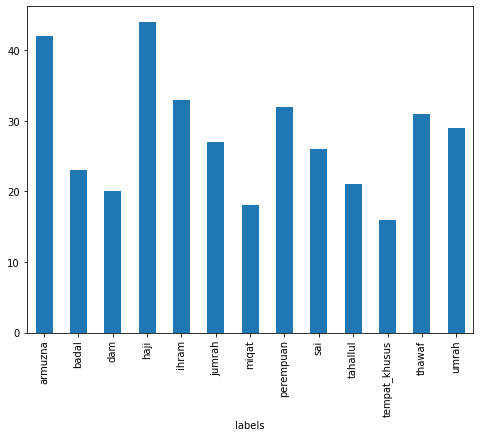

In [16]:
fig = plt.figure(figsize=(8,6))
df.groupby('labels').questions.count().plot.bar(ylim=0)
plt.show()

In [17]:
# df = preprocess_corpus(df, column='questions')
# df.head()

In [18]:
# untuk melihat hasi lebel yang telah diencode
list(le.classes_)
# labelEncode

['armuzna',
 'badal',
 'dam',
 'haji',
 'ihram',
 'jumrah',
 'miqat',
 'perempuan',
 'sai',
 'tahallul',
 'tempat_khusus',
 'thawaf',
 'umrah']

In [ ]:
# bagi data menjadi 2 train dan test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=20, stratify=y)

In [19]:
import pickle
# with open('pengujian/final/split_dataset/datset60.pickle', 'wb') as f:
#     pickle.dump([X_train, X_test, y_train, y_test], f)

In [20]:
with open('pengujian/final/split_dataset/datset60.pickle', 'rb') as f:
    X_train80, X_test80, y_train80, y_test80 = pickle.load(f)

In [ ]:
# checkpoint_path = 'data-target-model-wtl.h5'
# early_stopper = EarlyStopping(monitor='val_accuracy', patience=5, verbose=0, mode='auto')
# checkpointer = ModelCheckpoint(filepath=checkpoint_path, verbose=0, save_best_only=True)

# tinggal memnambahkan callback pada model fit
# untuk menyimpan model terbaik juga

In [21]:
# testing Glove
print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join('dataset/glove/vectors.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 331286 word vectors.


In [22]:
hits = 0
misses = 0
index = []
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        index.append(word)

In [23]:
# emb =  embeddings_index.get("kan")
# emb

In [24]:
# print("Converted %d words (%d misses)" % (hits, misses))

In [25]:
# create model CNN
def build_cnn_model():
    model = Sequential()
    
    model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCES_LENGTH,weights=[embedding_matrix],trainable=True))
   # model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCES_LENGTH))
    model.add(Conv1D(128, 3, padding='same', activation='relu'))
    # bisa menggunakan 128 atau 64
#     model.add(MaxPooling1D(2))

    model.add(GlobalMaxPooling1D())
#     model.add(Dropout(0.5))
#     model.add(Flatten())
    
    model.add(Dense(64,activation="relu"))
    model.add(Dense(13, activation='softmax'))
    
    model.compile(optimizer="adam",metrics=["accuracy"],loss="categorical_crossentropy")
    model.summary()
    return model

In [26]:
# Train Model
cnn_model = build_cnn_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            26750     
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 128)           19328     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 13)                845       
Total params: 55,179
Trainable params: 55,179
Non-trainable params: 0
_________________________________________________________________


In [27]:
cnn_history = cnn_model.fit(X_train80,y_train80,epochs=40,validation_data=(X_test80, y_test80))

Epoch 1/40
7/7 [==============================] - 14s 77ms/step - loss: 2.7059 - accuracy: 0.0978 - val_loss: 2.4842 - val_accuracy: 0.1379
Epoch 2/40
7/7 [==============================] - 0s 8ms/step - loss: 2.3510 - accuracy: 0.2635 - val_loss: 2.3349 - val_accuracy: 0.2483
Epoch 3/40
7/7 [==============================] - 0s 10ms/step - loss: 2.1511 - accuracy: 0.4289 - val_loss: 2.1928 - val_accuracy: 0.2966
Epoch 4/40
7/7 [==============================] - 0s 14ms/step - loss: 1.9109 - accuracy: 0.6157 - val_loss: 2.0580 - val_accuracy: 0.4069
Epoch 5/40
7/7 [==============================] - 0s 13ms/step - loss: 1.6619 - accuracy: 0.7320 - val_loss: 1.8766 - val_accuracy: 0.5172
Epoch 6/40
7/7 [==============================] - 0s 9ms/step - loss: 1.4164 - accuracy: 0.8073 - val_loss: 1.7008 - val_accuracy: 0.6138
Epoch 7/40
7/7 [==============================] - 0s 7ms/step - loss: 1.1664 - accuracy: 0.9008 - val_loss: 1.5317 - val_accuracy: 0.6552
Epoch 8/40
7/7 [=============

In [ ]:
# from keras.utils.vis_utils import plot_model
# plot_model(cnn_model, to_file='model1.png', show_shapes=True, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [30]:
# save model cnn
cnn_model.save('model60_e40.h5')

In [ ]:
# load model
# from keras.models import load_model

# cnn_model = load_model('pengujian/final/training60_e20/model60_e20.h5')

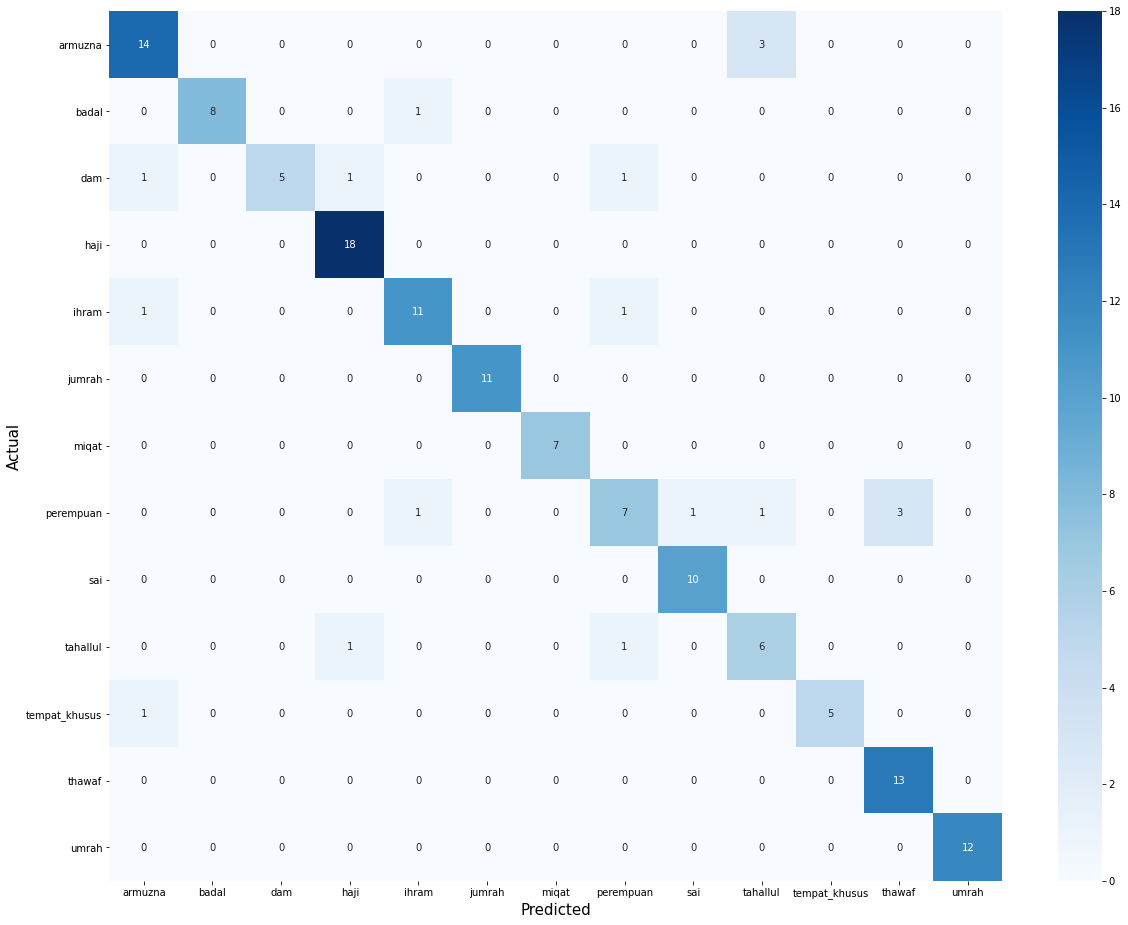

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
ypred = cnn_model.predict(X_test80)
cnn_accuracy = accuracy_score(y_test80.argmax(axis=-1),ypred.argmax(axis=-1))
#print("CNN Accuracy:",cnn_accuracy)
cnn_cn = confusion_matrix(y_test80.argmax(axis=-1),ypred.argmax(axis=-1))
plt.subplots(figsize=(20,16))
sns.heatmap(cnn_cn,annot=True,fmt="1d",cmap="Blues",cbar=True,xticklabels=le.classes_,yticklabels=le.classes_)
plt.xlabel("Predicted",fontsize=15)
plt.ylabel("Actual",fontsize=15)
plt.savefig('model60_e40.png')
plt.show()

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test80.argmax(axis=-1), ypred.argmax(axis=-1),target_names= le.classes_))

               precision    recall  f1-score   support

      armuzna       0.82      0.82      0.82        17
        badal       1.00      0.89      0.94         9
          dam       1.00      0.62      0.77         8
         haji       0.90      1.00      0.95        18
        ihram       0.85      0.85      0.85        13
       jumrah       1.00      1.00      1.00        11
        miqat       1.00      1.00      1.00         7
    perempuan       0.70      0.54      0.61        13
          sai       0.91      1.00      0.95        10
     tahallul       0.60      0.75      0.67         8
tempat_khusus       1.00      0.83      0.91         6
       thawaf       0.81      1.00      0.90        13
        umrah       1.00      1.00      1.00        12

     accuracy                           0.88       145
    macro avg       0.89      0.87      0.87       145
 weighted avg       0.88      0.88      0.87       145



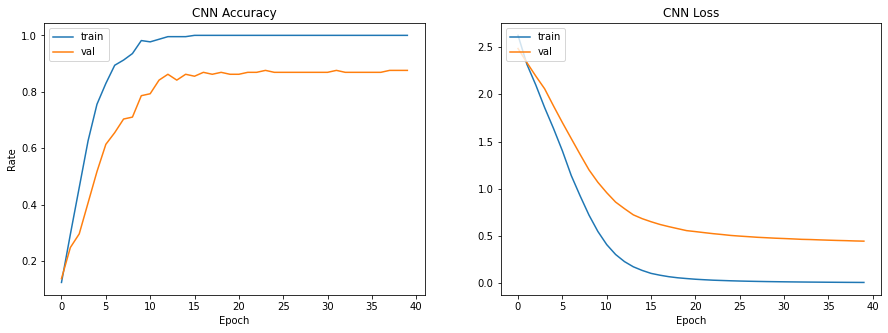

In [32]:
fig3, axe1 = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axe1[0].plot(cnn_history.history["accuracy"],label="accuracy")
axe1[0].plot(cnn_history.history["val_accuracy"],label="accuracy")
axe1[0].legend(['train', 'val'], loc='upper left')
axe1[1].plot(cnn_history.history["loss"],label="loss")
axe1[1].plot(cnn_history.history["val_loss"],label="loss")
axe1[1].legend(['train', 'val'], loc='upper left')
axe1[0].title.set_text("CNN Accuracy")
axe1[1].title.set_text("CNN Loss")
axe1[0].set_xlabel("Epoch")
axe1[1].set_xlabel("Epoch")
axe1[0].set_ylabel("Rate")
plt.show()

In [ ]:
from rake_nltk import Rake, Metric
from collections import Counter
import math

r = Rake(language="indonesian", min_length=1, max_length=5)

def counter(quest):
    counter = Counter(quest)
    return counter

def counter_cosine_similarity(c1, c2):
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)

def cnn_predict(quest):
    puretext = tokenizer.texts_to_sequences(quest)
    text_pad = pad_sequences(puretext,maxlen=50,padding='post')
    predicted = cnn_model.predict(text_pad)
    predicted_category = predicted.argmax(axis=1)
    return le.classes_[predicted_category]

def get_df(labels):
    dfNews = df.loc[df['labels'] == labels]
    npQuestions = dfNews.questions.to_numpy()
    npAnswers = dfNews.answers.to_numpy()
    return npQuestions,npAnswers

def rake_question(npQuestions, questUser):
    tempRake = []
    for i in range(len(npQuestions)):
        r.extract_keywords_from_text(npQuestions[i])
        tempRake.append(r.get_ranked_phrases())
    r.extract_keywords_from_text(questUser[0])
    qRake = r.get_ranked_phrases()
    return tempRake, qRake
    
def counter_result(tempRake, qRake):
    tempCounter = []
    for i in range(len(tempRake)):
        tempCounter.append(counter(tempRake[i]))
    counterQuestUser = counter(qRake)
    return tempCounter, counterQuestUser

def score_cosine(tempCounter, counterQuestUser):
    scoresCosine = []
    for i in range(len(tempCounter)):
        scoresCosine.append(counter_cosine_similarity(counterQuestUser, tempCounter[i]) * 100)
    npScore = np.array(scoresCosine)
    maxScore = np.amax(npScore)
    indexQuest = np.argmax(npScore)
    return maxScore, indexQuest

In [ ]:
questUser = ['bagaimana cara sai']

label = cnn_predict(questUser)
npQuestion , npAnswer = get_df(label[0])
tempRake, qRake = rake_question(npQuestion, questUser)
tempCounter, counterQuestUser = counter_result(tempRake, qRake)
maxScore, indexQuest = score_cosine(tempCounter, counterQuestUser)

print("label: " + label[0])
print("MaxScore " + str(maxScore))
print("prediksi question = " + npQuestion[indexQuest])
print("prediksi Answer = " + npAnswer[indexQuest])

In [ ]:
# Tambahan yg ada di backend dalam melakukan predict
# ini proses ketika sampai mendapatkan hasil intent

questUser = "Apa saja ibadah sa'i ciri-ciri yg boleh thowaf dilakukan oleh perempuan selama haid dalam ibadah haji?"

# 1. punctuation

character = '!"#$%&()*+,./:;<=>?@[\]^_`{|}~\'0123456789'
# #defining the function to remove punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in character])
    return punctuationfree

# 2. Normalisasi
# tokenizing tapi menggunakan fungsi split

# normalisasi dengan mengganti kata
def normalization(tokens):
    for idx, items in enumerate(tokens):
        for j in range(len(normalizad_word.before)):
            if items == normalizad_word.before[j]:
                tokens[idx] = normalizad_word.after[j]
    result_normalized = " ".join(tokens)
    return result_normalized
# 4. predict label
# def cnn_predict(quest):
#     puretext = tokenizer.texts_to_sequences(quest)
#     text_pad = pad_sequences(puretext,maxlen=50,padding='post')
#     predicted = cnn_model.predict(text_pad)
#     predicted_category = predicted.argmax(axis=1)
#     return le.classes_[predicted_category]


res = remove_punctuation(questUser)
# lakukan tokenizing (klu tidak bisa pake nltk bisa menggunkan spit saja)
tokens = res.split()
norm = normalization(tokens)
norm

In [ ]:
# untuk entity
# 1. puntuation
# 2. Normalisasi
# 3. Stemming
# 4. Rake

# gabungin dengan keduanya dengan cosine similarity

In [ ]:
puretext

batas

In [ ]:
# Mengambil data frame yg question
dfNew = df.loc[df['labels'] == 'investasi']

Menngunakan Rake untuk mencari jawaban

In [ ]:
# algoritma MIT Licesence https://github.com/csurfer/rake-nltk
from rake_nltk import Rake, Metric

TO CONTROL STOPWORD

    r = Rake(
        stopwords=<list of stopwords>,
        punctuations=<string of puntuations to ignore>
    )
    
TO CONTROL METRIC FOR RANKING

    # Paper uses d(w)/f(w) as the final metric. You can use this API with the
    # following metrics:

    # 1. d(w)/f(w) (Default metric) Ratio of degree of word to its frequency.
    r = Rake(ranking_metric=Metric.DEGREE_TO_FREQUENCY_RATIO)

    # 2. d(w) Degree of word only.
    r = Rake(ranking_metric=Metric.WORD_DEGREE)

    # 3. f(w) Frequency of word only.
    r = Rake(ranking_metric=Metric.WORD_FREQUENCY)
 
TO CONTROL THE MAX OR MIN WORDS IN A PHARSE

    r = Rake(min_length=2, max_length=4)


In [ ]:
# fungsi stopword indonesia
r = Rake(language="indonesian", min_length=1, max_length=5)

In [ ]:
# testing rake
textsu = "Dimana tempat untuk wukuf?"
r.extract_keywords_from_text(textsu)
r.get_ranked_phrases_with_scores()

Merubah question ke bentuk rake dan masukan kedalam list https://stackoverflow.com/questions/55162668/calculate-similarity-between-list-of-words

In [ ]:
npQuestions = dfNew.questions.to_numpy()
npAnswers = dfNew.answers.to_numpy()

In [ ]:
# mencari keyword di setiap list pertanyaan
tempRake = []
for i in range(len(npQuestions)):
    r.extract_keywords_from_text(npQuestions[i])
    tempRake.append(r.get_ranked_phrases())

In [ ]:
# Mencari keyword question yang diajukan user
# questUser = "Apa ciri-ciri bank Syariah?"
r.extract_keywords_from_text(questUser[0])
qRake = r.get_ranked_phrases()

In [ ]:
# Menghitung Cosine Similiarity
from collections import Counter
import math

def counter(quest):
    counter = Counter(quest)
    return counter

def counter_cosine_similarity(c1, c2):
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)

In [ ]:
counterQuestUser = counter(qRake)

In [ ]:
tempCounter = []
for i in range(len(tempRake)):
    tempCounter.append(counter(tempRake[i]))

In [ ]:
scoresCosine = []
for i in range(len(tempCounter)):
    scoresCosine.append(counter_cosine_similarity(counterQuestUser, tempCounter[i]) * 100)

In [ ]:
npScore = np.array(scoresCosine)
maxScore = np.amax(npScore)
indexQuest = np.argmax(npScore)

In [ ]:
print("prediksi question = " + npQuestions[indexQuest])
print("prediksi Answer = " + npAnswers[indexQuest])

Menghitung hasil dari Accuracy dan Precision dari Model CNN

In [33]:
predictions = cnn_model.predict(X_test80)
predictions = [np.argmax(predictions[i]) for i in range(len(predictions))]
predictions = np.array(predictions)
labels = [np.argmax(y_test80[i]) for i in range(len(y_test80))]
labels = np.array(labels)

In [34]:
from sklearn import metrics

print ("Accuracy: " + str(100*metrics.accuracy_score(labels, predictions)))
print ("Precision: " + str(100*metrics.precision_score(labels, predictions, average="weighted")))
print ("Recall: " + str(100*metrics.recall_score(labels, predictions, average="weighted")))
print ("f1_score: " + str(100*metrics.f1_score(labels, predictions, average="weighted")))

Accuracy: 87.58620689655172
Precision: 88.10579937304077
Recall: 87.58620689655172
f1_score: 87.28066908402063
